In [1]:
# Check if running in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  

In [2]:
if IN_COLAB :
    # If we are in colab we don't have access to our custom modules so we clone the repository
    !git clone https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor.git
    # Pull last data from git
    !cd clothes-extractor && git pull && cd ..


In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [4]:
if IN_COLAB :
  # Import code form our github
  from pathlib import Path

  current_folder = globals()['_dh'][0]
  parent = Path(current_folder).parent
  os.chdir(os.path.join(current_folder, "clothes-extractor"))
  print(os.getcwd())
  
# Project imports
from src.dataset import ClothesDataLoader, ClothesDataset
from src.config import Config
from src.model import Unet
from src.train import train_model

In [5]:
seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

mps


In [7]:
# Type here the path for the data set
dataset_path = os.path.join("datasets", "zalando-hd-resized")
!pwd

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  !wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  !echo "Extracting the dataset. Please wait...."
  !unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  !rm path_check.tmp
  !rm zalando-hd-resized.zip
  print("Done")

/Users/acabanas/dev/forks/clothes-extractor/Jupyters
Dataset already downloaded


In [8]:
cfg = Config()
cfg.batch_size = 10
cfg.dataset_dir = dataset_path
cfg.load_height = 28
cfg.load_width = 28
cfg.learning_rate = 0.0002
cfg.num_epochs = 1
cfg.num_val_samples = 10
cfg.num_input_channels = 1
cfg.num_classes = 10

In [9]:

test_dataset = ClothesDataset(cfg, "test")
train_dataset = ClothesDataset(cfg, "train")

test_dataloader = ClothesDataLoader(test_dataset, cfg.batch_size, num_workers=cfg.workers)
train_dataloader = ClothesDataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.workers)

/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


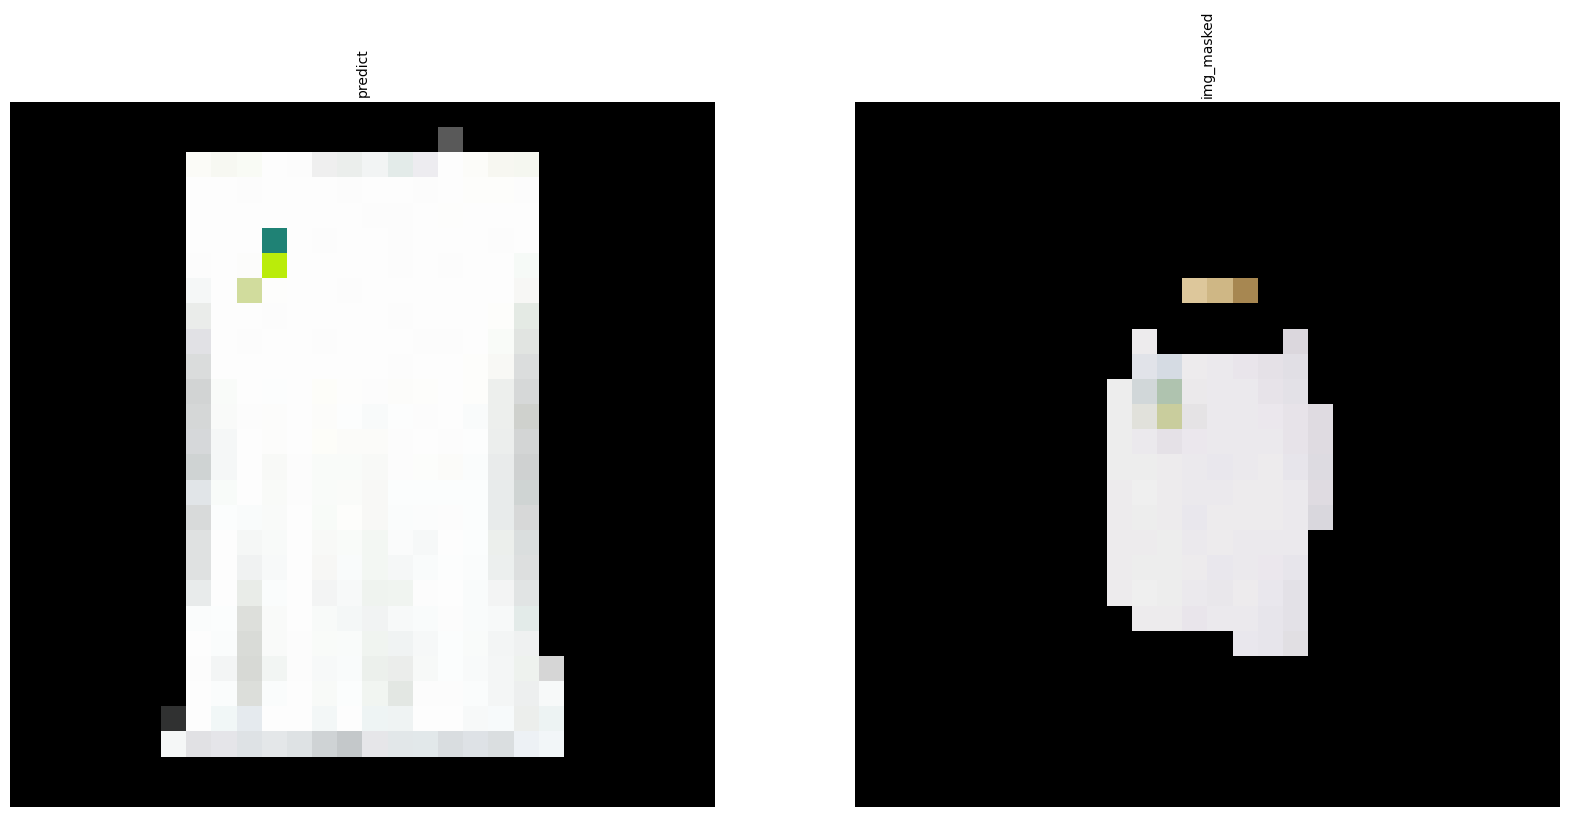

In [10]:
image = train_dataset[2]

# image_keys = ["img", "cloth", "cloth_mask", "predict", "agnostic_mask", "mask_body_parts", "mask_body", "centered_mask_body", "img_masked"]
image_keys = ["predict", "img_masked"]
fig, axes = plt.subplots(1, len(image_keys), figsize=(20, 20))

for ax, key in zip(axes, image_keys):
    ax.imshow(image[key].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(key, rotation=90, fontsize=10)

# Defining the UNET
![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

We are using the Unet defined in the [Model module from the repository](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/model.py)

In [11]:

def visualize_nn_output(output, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()

    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = np.transpose(output, (1, 2, 0))

    plt.imshow(output)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


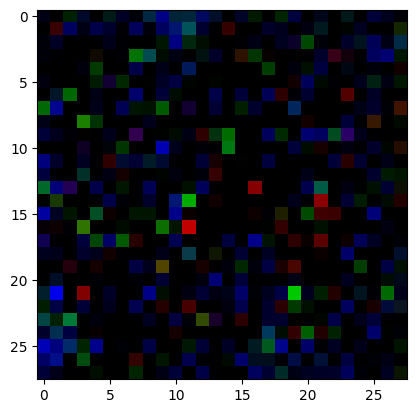

In [12]:
model = Unet(in_channels=3, n_feat=32)
inp = torch.randn(2,3,28,28) #As a sanity check, we define a random tensor with the same shape as an input image, to make sure that we can forward it to our network
out = model(inp)

visualize_nn_output(out)

The Train model function is the defined in the [train module from the project](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/train.py)


In [13]:
def run_model_on_image(model, dataset, image_index):
    model.eval()
    
    image = dataset[image_index]
    image = image["img_masked"].unsqueeze(0)

    
    with torch.no_grad():
        output = model(image)

    return output


In [14]:
# For testing purposes (There are so many images) we can limit the number of loaded batches, 0 is no limit
cfg.max_batches = 1

trained_model = train_model(model, train_dataloader, test_dataloader, cfg.num_epochs, cfg.learning_rate, cfg.max_batches)


Start training


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

Epoch [1/1], Train Loss: 0.0013, Validation Loss: 0.0051
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


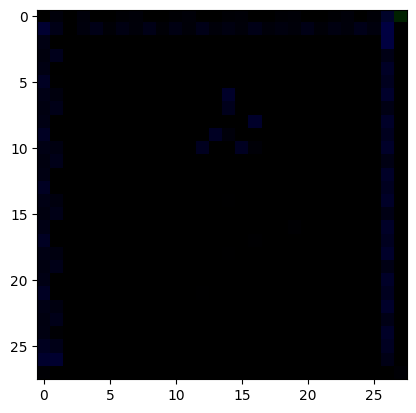

In [16]:
out = run_model_on_image(model, train_dataset, 0)
visualize_nn_output(out)

In [17]:
import src.dataset as dataset
import importlib
importlib.reload(dataset)

<module 'src.dataset' from '/Users/acabanas/dev/forks/clothes-extractor/src/dataset.py'>